# LieGG for invariant regression minimal example 

In [2]:
import sys
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from src.datasets import O5Synthetic
from src.models import MLP, Standardize
from src.liegg import polarization_matrix_1, symmetry_metrics
from src.utils import split_data

import matplotlib.pyplot as plt
%matplotlib inline

### Train utils:

In [3]:
# takes a model and trains it on the O5 dataset
# implemented for CPU

def train(model, training_set_size, seed=2022):
        
    # fix seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # define dataset
    base_dataset = O5Synthetic(training_set_size)
    datasets = split_data(base_dataset, 
                          splits={'train':-1,'val':250,'test':250},
                          seed=seed)
    
    # define model & opt
    model = Standardize(model, base_dataset.stats)
    optimizer = torch.optim.Adam(model.parameters(), lr = 3e-3, weight_decay=1e-4)
    
    # define opt routines
    loss = torch.nn.MSELoss()

    n_epochs = int(900000/training_set_size)
    batch_size = 500
    bs = batch_size
    dataloaders = {k:DataLoader(v,batch_size=min(bs,len(v)),shuffle=(k=='train'),
                num_workers=0,pin_memory=False) for k,v in datasets.items()}
    dataloaders['Train'] = dataloaders['train']
    
    # validate before
    model.eval()
    for (x_test, y_test) in dataloaders['test']:
        y_pred = model(x_test.float())
        after_train = loss(y_pred, y_test.float()) 
        print('Test loss before Training' , after_train.item())
        
    # loop train
    model.train(True)
    for epoch in range(n_epochs):
        running_loss  = 0
        for i, (inputs, labels) in enumerate(dataloaders['Train'], 0):
            
            optimizer.zero_grad()
            
            outputs = model(inputs.float())
            loss_ = loss(outputs, labels.float())
            loss_.backward()
            optimizer.step()

            # log statistics
            running_loss += loss_
            if i % 10 == 0:
                sys.stdout.write('[%d, %5d] loss: %.3f\r' %
                  (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0
    
    # validate after
    model.eval()
    for (x_test, y_test) in dataloaders['test']:
        y_pred = model(x_test.float())
        after_train = loss(y_pred, y_test.float()) 
        print('Test loss after Training' , after_train.item())
        
    return model, base_dataset.X, base_dataset.stats

_________________________________

### LieGG:

In [4]:
# define and train the model
model = MLP(in_dim = 10, out_dim = 1, ch=32, num_nonlins=2)
trained_model, data, data_stats = train(model, training_set_size=10000, seed=2022)

Test loss before Training 35.77134323120117
Test loss after Training 0.22237414121627808


In [5]:
# compute the network polarization matrix
data_X = torch.FloatTensor(data)
E = polarization_matrix_1(trained_model, data_X)

In [6]:
# compute symmetry variance and bias
singular_values, symmetry_biases, _ = symmetry_metrics(E)

print('Symmetry variance: ', singular_values[-1].item())
print('min Symmetry bias: ', symmetry_biases[-1].item())

Symmetry variance:  0.0633259192109108
min Symmetry bias:  0.009288029745221138


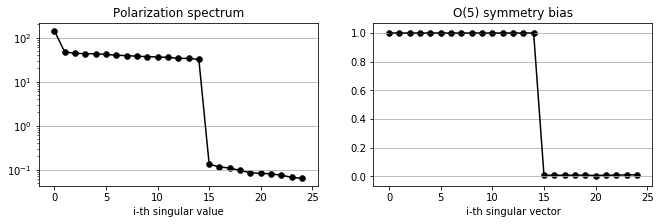

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(11, 3))

ax[0].grid(axis='y')
ax[0].plot(singular_values.data, color='black')
ax[0].scatter(torch.arange(singular_values.shape[0]), singular_values.data, color='black', linewidths=.5)
ax[0].set_yscale('log')
ax[0].set_title('Polarization spectrum')
ax[0].set_xlabel('i-th singular value')

ax[1].grid(axis='y')
ax[1].plot(symmetry_biases.data, color='black')
ax[1].scatter(torch.arange(symmetry_biases.shape[0]), symmetry_biases.data, color='black', linewidths=.5)
ax[1].set_title('O(5) symmetry bias')
ax[1].set_xlabel('i-th singular vector')
plt.show();